# Some Data Exploration for the White Wine Dataset

## Import the libraries

In [58]:
import sys
from pathlib import Path

import torch
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy import stats

## Load the data

In [3]:
INPUT_DATA_PATH = Path("../data/winequality-white.csv")
dataset_df = pd.read_csv(INPUT_DATA_PATH, sep=";")

## Some Data Trend Exploration

In [4]:
dataset_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
dataset_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [6]:
dataset_df['quality'].value_counts()

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64

<Axes: xlabel='quality'>

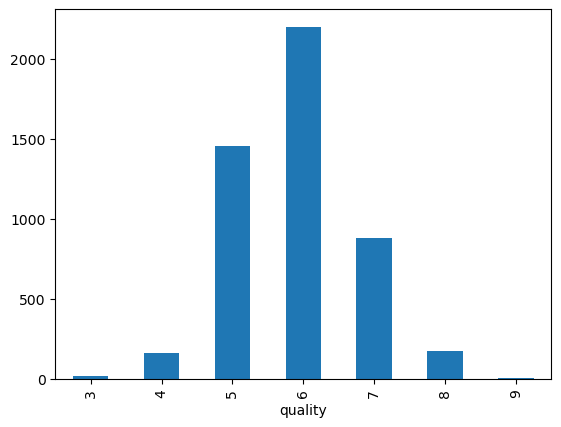

In [35]:
dataset_df.groupby('quality').size().plot(kind="bar")

<Axes: >

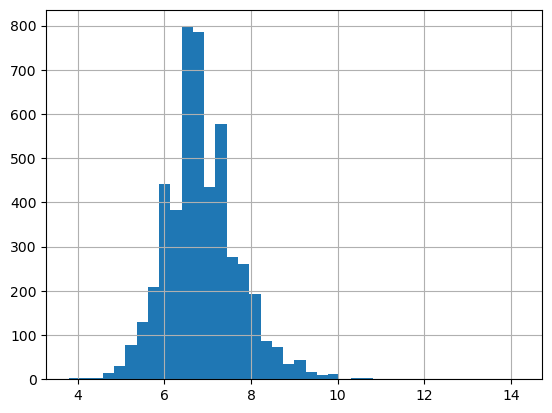

In [66]:
dataset_df['fixed acidity'].hist(bins=40)

In [88]:
dataset_df[dataset_df['fixed acidity'] >= 10]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
207,10.2,0.44,0.88,6.2,0.049,20.0,124.0,0.9968,2.99,0.51,9.9,4
358,10.0,0.20,0.39,1.4,0.050,19.0,152.0,0.9940,3.00,0.42,10.4,6
873,10.3,0.17,0.47,1.4,0.037,5.0,33.0,0.9939,2.89,0.28,9.6,3
1239,10.3,0.25,0.48,2.2,0.042,28.0,164.0,0.9980,3.19,0.59,9.7,5
1372,10.7,0.22,0.56,8.2,0.044,37.0,181.0,0.9980,2.87,0.68,9.5,6
1373,10.7,0.22,0.56,8.2,0.044,37.0,181.0,0.9980,2.87,0.68,9.5,6
1526,14.2,0.27,0.49,1.1,0.037,33.0,156.0,0.9920,3.15,0.54,11.1,6
1856,10.0,0.91,0.42,1.6,0.056,34.0,181.0,0.9968,3.11,0.46,10.0,4
1900,10.0,0.23,0.27,14.1,0.033,45.0,166.0,0.9988,2.72,0.43,9.7,6
2050,11.8,0.23,0.38,11.1,0.034,15.0,123.0,0.9997,2.93,0.55,9.7,3


((array([-3.41809637, -3.16880263, -3.03062888, ...,  3.03062888,
          3.16880263,  3.41809637]),
  array([ 3.8,  4.4,  4.7, ..., 10.7, 10.7, 14.2])),
 (0.8261616712648889, 6.837670609645132, 0.9853851117548065))

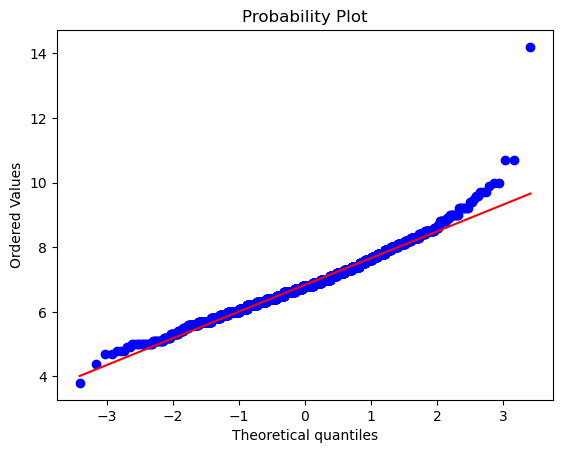

In [71]:
mask = dataset_df['quality'] == 6
stats.probplot(dataset_df[mask]['fixed acidity'], dist="norm", plot=plt)

In [87]:
dataset_df[dataset_df['citric acid'] >= 1]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
745,7.4,0.200,1.66,2.10,0.022,34.0,113.0,0.99165,3.26,0.55,12.2,6
946,8.2,0.345,1.00,18.20,0.047,55.0,205.0,0.99965,2.96,0.43,9.6,5
1722,7.5,0.400,1.00,19.50,0.041,33.0,148.0,0.99770,3.24,0.38,12.0,6
1775,7.7,0.490,1.00,19.60,0.030,28.0,135.0,0.99730,3.24,0.40,12.0,6
3043,7.2,0.210,1.00,1.10,0.154,46.0,114.0,0.99310,2.95,0.43,9.2,6
3152,7.6,0.250,1.23,4.60,0.035,51.0,294.0,0.99018,3.03,0.43,13.1,6
3497,7.7,0.430,1.00,19.95,0.032,42.0,164.0,0.99742,3.29,0.50,12.0,6


((array([-3.63037229, -3.39472968, -3.26483892, ...,  3.26483892,
          3.39472968,  3.63037229]),
  array([0.  , 0.  , 0.  , ..., 1.  , 1.23, 1.66])),
 (0.11624027005127821, 0.33419150673744386, 0.9599514246960369))

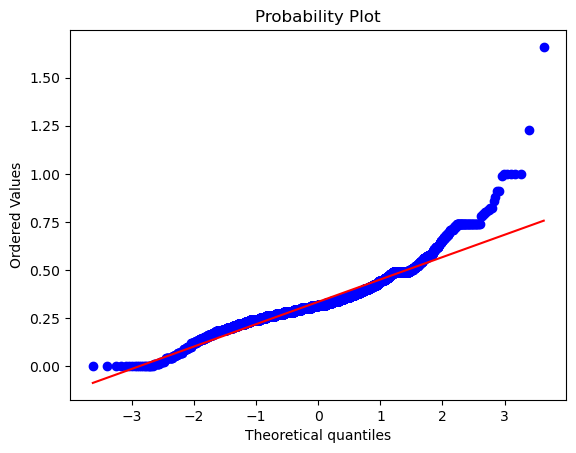

In [84]:
stats.probplot(dataset_df['citric acid'], dist="norm", plot=plt)

In [89]:
dataset_df[dataset_df['residual sugar'] > 40]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2781,7.8,0.965,0.6,65.8,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6


((array([-3.63037229, -3.39472968, -3.26483892, ...,  3.26483892,
          3.39472968,  3.63037229]),
  array([ 0.6,  0.6,  0.7, ..., 31.6, 31.6, 65.8])),
 (4.771710793196471, 6.391414863209473, 0.9402406304685053))

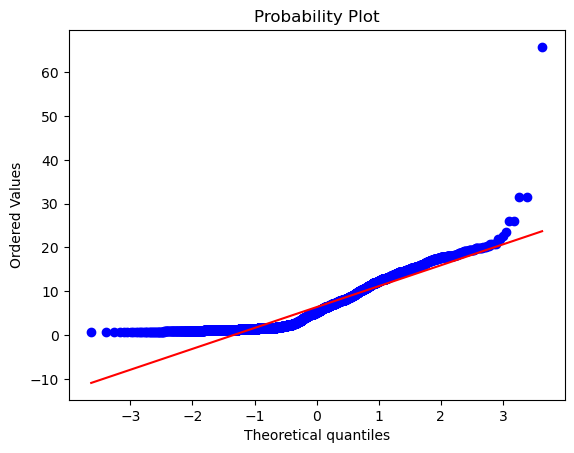

In [86]:
stats.probplot(dataset_df['residual sugar'], dist="norm", plot=plt)

<Axes: xlabel='quality'>

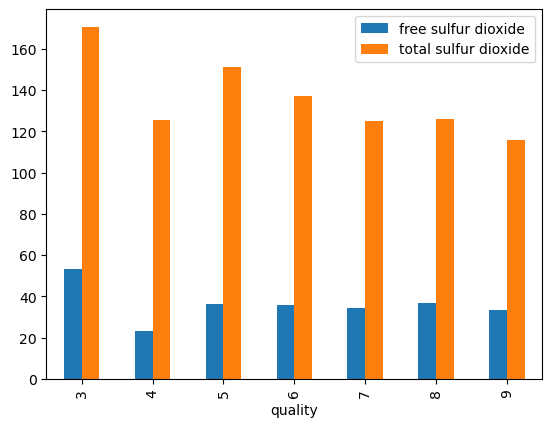

In [8]:
dataset_df.groupby(['quality']).mean().plot(kind="bar", y=["free sulfur dioxide", "total sulfur dioxide"])

In [9]:
dataset_df.groupby(['quality'])[["free sulfur dioxide", "total sulfur dioxide"]].corr()

free sulfur dioxide  total sulfur dioxide
quality                                                                
3       free sulfur dioxide              1.000000              0.776483
        total sulfur dioxide             0.776483              1.000000
4       free sulfur dioxide              1.000000              0.657583
        total sulfur dioxide             0.657583              1.000000
5       free sulfur dioxide              1.000000              0.664293
        total sulfur dioxide             0.664293              1.000000
6       free sulfur dioxide              1.000000              0.596310
        total sulfur dioxide             0.596310              1.000000
7       free sulfur dioxide              1.000000              0.532689
        total sulfur dioxide             0.532689              1.000000
8       free sulfur dioxide              1.000000              0.621078
        total sulfur dioxide             0.621078              1.000000
9       free sulfur dioxide              1.000000              0.168112
        total sulfur dioxide             0.168112              1.000000

<Axes: xlabel='quality'>

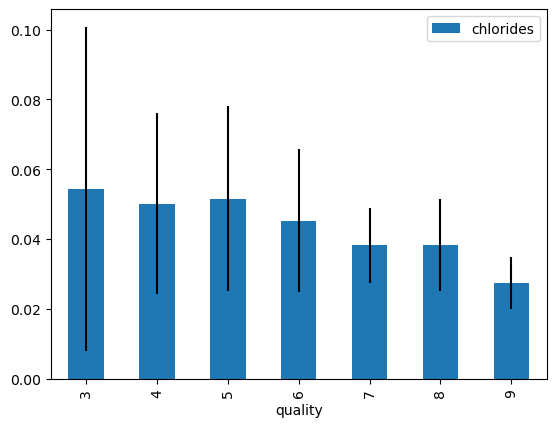

In [10]:
std_devs = dataset_df.groupby(['quality'])[["chlorides"]].std()
dataset_df.groupby(['quality']).mean().plot(kind="bar", y=["chlorides"], yerr=std_devs)

<Axes: xlabel='quality'>

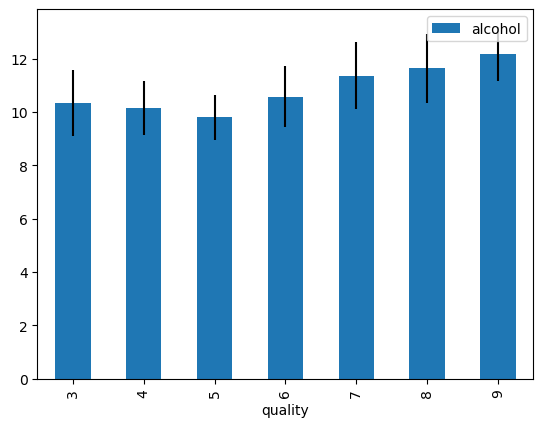

In [11]:
std_devs = dataset_df.groupby(['quality'])[["alcohol"]].std()
dataset_df.groupby(['quality']).mean().plot(kind="bar", y=["alcohol"], yerr=std_devs)

## Load the PyTorch Model to do Prediction Exploration

In [12]:
sys.path.append('..')
import pytorch.train as pyttrain

In [13]:
device = pyttrain.get_device()
model = pyttrain.NeuralNetwork().to(device)

In [14]:
model.load_state_dict(torch.load("../pytorch" / pyttrain.OUTPUT_MODEL_PATH))

with open("../pytorch" / pyttrain.TRAIN_DATASET_PATH, "rb") as f:
    train_dataset = pickle.load(f)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=pyttrain.BATCH_SIZE)

with open("../pytorch" / pyttrain.VALIDATE_DATASET_PATH, "rb") as f:
    validate_dataset = pickle.load(f)
validate_dataloader = torch.utils.data.DataLoader(validate_dataset, batch_size=pyttrain.BATCH_SIZE)

with open("../pytorch" / pyttrain.TEST_DATASET_PATH, "rb") as f:
    test_dataset = pickle.load(f)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=pyttrain.BATCH_SIZE)

## Predict from the Train/Test Datasets

In [24]:
train_pred_scores = []
for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    train_pred_scores += pred.round().tolist()

validate_pred_scores = []
for X, y in validate_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    validate_pred_scores += pred.round().tolist()

test_pred_scores = []
test_true_scores = []
for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    test_pred_scores += pred.round().tolist()
    test_true_scores += y.tolist()

## Explore Trends in the Predictions

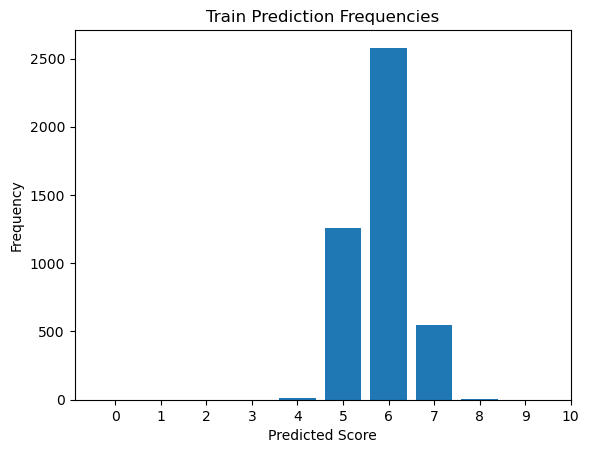

In [16]:
# Create histogram
plt.hist(train_pred_scores, bins=range(11), align='left', rwidth=0.8)

# Set labels and title
plt.title('Train Prediction Frequencies')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.xticks(range(11))

# Show plot
plt.show()

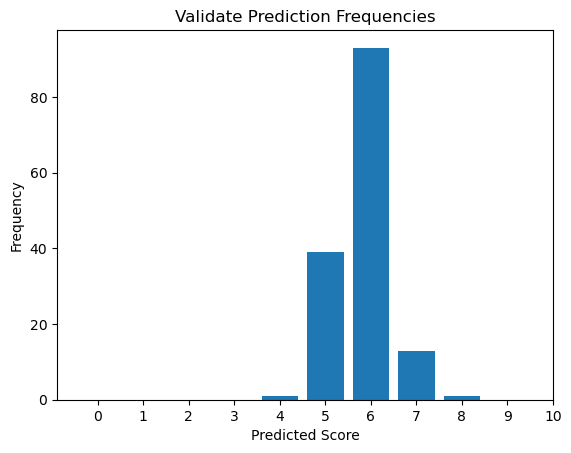

In [17]:
# Create histogram
plt.hist(validate_pred_scores, bins=range(11), align='left', rwidth=0.8)

# Set labels and title
plt.title('Validate Prediction Frequencies')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.xticks(range(11))

# Show plot
plt.show()

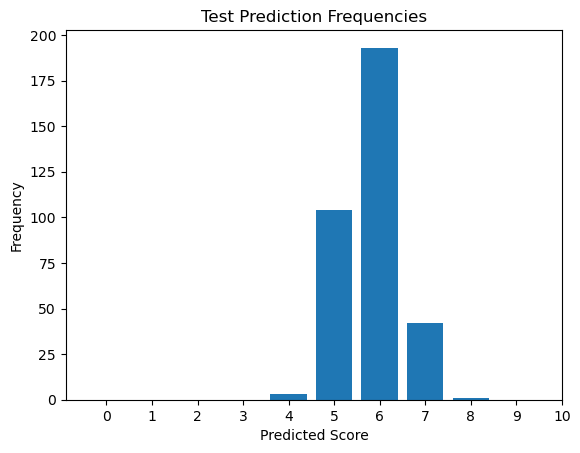

In [18]:
# Create histogram
plt.hist(test_pred_scores, bins=range(11), align='left', rwidth=0.8)

# Set labels and title
plt.title('Test Prediction Frequencies')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.xticks(range(11))

# Show plot
plt.show()

## Analyze via Confusion Matrix

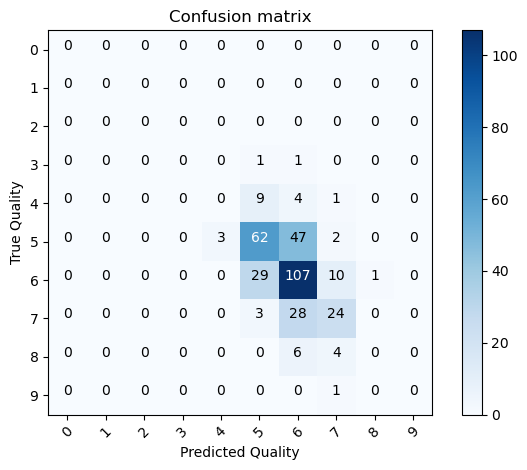

In [31]:
classes = list(range(10))

y_true = test_true_scores
y_pred = test_pred_scores

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=classes)

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = list(range(len(classes)))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True Quality')
plt.xlabel('Predicted Quality')
plt.tight_layout()
plt.show()